## NLP Sentiment Analysis of Tweets Identifying Natural Disasters

---

Twitter has become an important communication channel in times of emergency.
The wide-spread use of smartphones enables people to identify and announce emergencies they’re observing in almost real-time. As a result, there is growing interest in programatically monitoring Twitter to identify and respond to emergencies more rapidly. However, it’s not always clear whether a person’s words are actually announcing a disaster. For example, someone might tweet that 'the sky was abaze', or 'a sports player was on fire'; both of which are used metaphorically and do not signify real emergencies. 

Therefore, the purpose of this notebook is to explore different classification models for performing sentiment analysis on a data set of pre-label tweets from figure-eight that can be found [here](https://www.kaggle.com/c/nlp-getting-started/data).

We start with some basic cleaning of the text before lematizing and tokenizing the words. KFold stratified cross-validation is then used to evaluate the performance of various models by training on a test set and making predictions on a validation set. The models considered here include:

i) Linear ridge classification,<br>
ii) Logistic regression,<br>
iii) XGBoost classifier, and<br>
iv) A 'deep' feed-forward sequential nerual network.


This is considered a higher-level exploratory analysis so in-depth hyperparamter optimization is not performed for the models considered. Indeed, this could be a seprate analysis on its own, especially for the deep learning networks. 

*Based on the notebook submitted to the Kaggle competition: Natural Language Processing with Disaster Tweets*

---

### Setup 

Let's start by installing the necessary version of scikit-learn (to use the library plot_confusion_matrix), and loading in the necessary libraries for the analysis.

In [1]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==0.24

Found existing installation: scikit-learn 0.24.0
Uninstalling scikit-learn-0.24.0:
  Successfully uninstalled scikit-learn-0.24.0
  Using cached scikit_learn-0.24.0-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)


In [2]:
# import libraries
import numpy as np 
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# scikit-learn libraries
from sklearn import (feature_extraction, linear_model,
                     model_selection, preprocessing)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score, 
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.preprocessing import text, sequence
# nltk (Natural Language ToolKit) libraries
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# mount Google drive
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


First we define some hyperparameters that we need for data preprocessing and model training.

In [3]:
hparams = {
    'batch_size': 256,
    'epochs': 500,
    'learning_rate': 0.005,
    'max_num_words': 10000,
    'max_sequence_length': 500
}

Load in the data and generate a training and validation set:

In [4]:
# load in data
other_df = pd.read_csv('/content/drive/MyDrive/ml_datasets/nlp_tweet_disasters/train.csv')
X_test = pd.read_csv('/content/drive/MyDrive/ml_datasets/nlp_tweet_disasters/test.csv')

# separate into features (X) and target (y)
X = other_df.copy()
y = X.pop('target')

# remove id
X.drop('id', axis = 1, inplace = True)

X.head(10)

,keyword,location,text
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
1,NaN,NaN,Forest fire near La Ronge Sask. Canada
2,NaN,NaN,All residents asked to 'shelter in place' are ...
3,NaN,NaN,"13,000 people receive #wildfires evacuation or..."
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...
5,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...
6,NaN,NaN,#flood #disaster Heavy rain causes flash flood...
7,NaN,NaN,I'm on top of the hill and I can see a fire in...
8,NaN,NaN,There's an emergency evacuation happening now ...
9,NaN,NaN,I'm afraid that the tornado is coming to our a...


### Explore the data

Let's examine the data for missing values, and examples of tweets that are and are not disasters.

In [5]:
print('----- Not a disaster -----')
print(X[y == 0]["text"].values[1])

print('----- Is a Disaster -----')
print(X[y == 1]["text"].values[10])

----- Not a disaster -----
I love fruits
----- Is a Disaster -----
Three people died from the heat wave so far


In [6]:
# check for missing values
X.isnull().sum()

keyword       61
location    2533
text           0
dtype: int64

There are missing values in keyword and location, but none in text. To start, we will perform the analysis assuming that the words in each tweet are a good indicator of whether or not it's about a real disaster. This is not enitrely correct, but it is a good place to start.

---

### Preprocess tweets and build vocabulary

Next, we tokenize the text from each tweet using the `Tokenizer` from Keras. We will form a vocabulary based on the training tweets alone and convert all tweets into a dense tensor of tokens having the same length.

In [7]:
# lets clean up the tweets and lemmatize 
# lemmatization considers the context and converts the word to its meaningful base form
# WordNetLemmatizer from the nltk package - imported stop words to remove from texts
lemma = WordNetLemmatizer()

# count vector implements tokenizing and occurrence counting in a single class
# we will account for unigrams (1 word sequence) and bigrams (2 word sequences) using 
# the ngram_range= (1,2) - unigrams only = (1,1), bigrams only = (2,2)
count_vectorizer = CountVectorizer(ngram_range=(1,2), max_features = hparams['max_sequence_length'])

# we will store our cleaned texts in a text corpus list
text_corpus = []

# loop through all tweets and clean up (first without lemmatizing)
for i in range(len(X)):
    tweet = re.sub(r'https?://\S+|www\.\S+','', X.loc[i,'text'])
    tweet = re.sub(r'<.*?>','', tweet)
    tweet = re.sub('[^a-zA-Z]',' ', tweet)
    tweet = tweet.lower()
    tweet = tweet.split()
    tweet = [lemma.lemmatize(word) for word in tweet if not word in stopwords.words('english')]
    tweet = ' '.join(tweet)
    text_corpus.append(tweet)

# fit the vectorizer to the cleaned tweets
x = count_vectorizer.fit_transform(text_corpus).toarray()

# split into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(x, y, stratify = y, train_size=0.8, random_state = 1)

# tranform test set tweets into word vectors
test_vectors = count_vectorizer.transform(X_test["text"])

'''
# Tensorflow implementation

# be default, removes all punctuation
tokenizer = text.Tokenizer(lower = True, num_words = hparams['max_num_words'])

# update vocabulary based on list of texts 
tokenizer.fit_on_texts(text_corpus)

# create  a function to turn the text into padded sequences
def pad_tweets(text, tokenizer, max_sequence_length):
    # transform each text in the tweet to a sequence of integers based on tokenizer vocab we created
    text_sequences = tokenizer.texts_to_sequences(text)
    return sequence.pad_sequences(text_sequences, maxlen = max_sequence_length)

# process train, val and test tweets
x = pad_tweets(text_corpus, tokenizer, hparams['max_sequence_length'])
'''

"\n# Tensorflow implementation\n\n# be default, removes all punctuation\ntokenizer = text.Tokenizer(lower = True, num_words = hparams['max_num_words'])\n\n# update vocabulary based on list of texts \ntokenizer.fit_on_texts(text_corpus)\n\n# create  a function to turn the text into padded sequences\ndef pad_tweets(text, tokenizer, max_sequence_length):\n    # transform each text in the tweet to a sequence of integers based on tokenizer vocab we created\n    text_sequences = tokenizer.texts_to_sequences(text)\n    return sequence.pad_sequences(text_sequences, maxlen = max_sequence_length)\n\n# process train, val and test tweets\nx = pad_tweets(text_corpus, tokenizer, hparams['max_sequence_length'])\n"

Verify that regex filtering and token sequencing worked

In [8]:
text_trial = X.text.iloc[0:3]

print(text_trial.iloc[0:3])

## let's get counts for the first 5 tweets in the data
example_train_vectors = count_vectorizer.fit_transform(X.text.iloc[0:5])

## we use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

'''
# Tensorflow checks
seq = tokenizer.texts_to_sequences(text_trial)
print(tokenizer.sequences_to_texts(seq))
'''

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
Name: text, dtype: object
(1, 113)
[[0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0
  1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1
  1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0
  1 1 0 0 0]]


'\n# Tensorflow checks\nseq = tokenizer.texts_to_sequences(text_trial)\nprint(tokenizer.sequences_to_texts(seq))\n'

The above tells us that:
1. There are 113 unique words (or "tokens") in the three tweets.
2. The first tweet contains only some of those unique tokens - all of the non-zero counts above are the tokens that exist in the first tweet.

### Ridge regression classifier model

As we mentioned above, we think the words contained in each tweet are a good indicator of whether they're about a real disaster or not. The presence of particular word (or set of words) in a tweet might link directly to whether or not that tweet is real.

What we're assuming here is a _linear_ connection. Note that our vectors are really big, so we want to push our model's weights toward 0 without completely discounting different words - ridge regression is a good way to do this. So let's build a linear model and see!

In [9]:
# create an instance of the ridge classifier model and train on the training set
clf = linear_model.RidgeClassifier()
clf.fit(X_train, y_train)

RidgeClassifier()

Let's test our model on the validation data and evaluate the performance through the confusion matrix. 

F1 score: 0.723, F1 score (computed): 0.723
----- Confusion Matrix -----


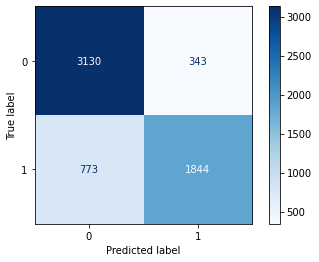

In [10]:
# predict classes for isntances in the validation set and compute the F1 score
predictions = clf.predict(X_valid)
f1score = f1_score(predictions, y_valid)

# lets verify the computation of f1 score
prec = precision_score(predictions, y_valid)
recall = recall_score(predictions, y_valid)
f1_compute = 2*prec*recall/(prec+recall)

print('F1 score: {:.3f}, F1 score (computed): {:.3f}'.format(f1score, f1_compute))

print('----- Confusion Matrix -----')
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_train, y_train, cmap='Blues')

 Let's write our own cross validation function to work on the pre-cleaned training and validation data. The metric for this competition is F1, so let's use that here.

*Recall, the F1 score is calculated as 2*(precision*recall)/(precision + recall)*

In [11]:
# define a helper function for performing KFold cross-validation
def cross_val_scores(model, x, y, k, scores):
    skf = StratifiedKFold(n_splits = k, shuffle = True, random_state = 1)

    for train_index, val_index in skf.split(x, y):
        xt, xv = x[train_index], x[val_index]
        yt, yv = y[train_index], y[val_index]
        
        model.fit(xt, yt)
        predictions = model.predict(xv)
        scores.append(f1_score(yv, predictions))
        
    return scores
    
scores = []
scores = cross_val_scores(clf, x, y, 5, scores)
print(' ----- Cross-validation F1 scores -----')
print(scores)

 ----- Cross-validation F1 scores -----
[0.7262200165425973, 0.7065767284991569, 0.7230514096185737, 0.7228714524207012, 0.7187237615449202]


The above scores aren't terrible! However, there are many ways to potentially improve on this. Two ways we will consider are boosted random forest (xgboost) and a deep learning model.

### Logistic regression model

F1 score: 0.729
 ----- Cross-validation F1 scores -----
[0.732463295269168, 0.7215295095594347, 0.7176954732510288, 0.7231920199501246, 0.730800323362975]
----- Confusion Matrix -----


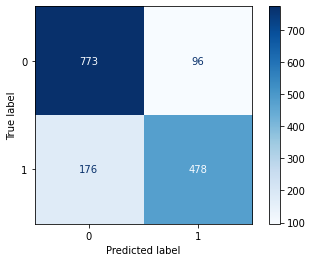

In [12]:

log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)

predictions = log_clf.predict(X_valid)
f1score = f1_score(predictions, y_valid)

print('F1 score: {:.3f}'.format(f1score))

# perform kFold cross validation
scores = []
scores = cross_val_scores(log_clf, x, y, 5, scores)
print(' ----- Cross-validation F1 scores -----')
print(scores)

# compute confusion matrix
print('----- Confusion Matrix -----')
plot_confusion_matrix(log_clf, X_valid, y_valid, cmap='Blues')

The logistic regression model has a very similar performance to the ridge classifier. We may consider changing the default decision boundary threshold with logisitic regression to tailor the performance to avoid false-positives/false-negatives depending on the applications, though we won't consider that here.

Now let's try an XGBoost classifier.

### XGBoost Model

Now let's use an XGBoost classifier to perform sentiment classification.

F1 score: 0.703
 ----- Cross-validation F1 scores -----
[0.7214225232853515, 0.6934046345811052, 0.6993006993006993, 0.7132987910189983, 0.7215081405312768]
----- Confusion Matrix -----


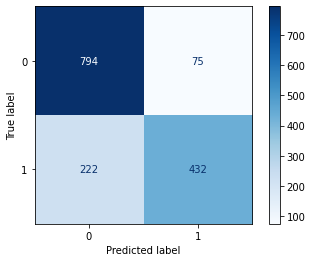

In [13]:
xgb = XGBClassifier(max_depth = 3, objective='binary:logistic', learning_rate = 0.5)
xgb.fit(X_train, y_train)
# make predictions on the validation set
predictions = xgb.predict(X_valid)
f1score = f1_score(predictions, y_valid)

print('F1 score: {:.3f}'.format(f1score))

# perform kFold cross validation
scores = []
scores = cross_val_scores(xgb, x, y, 5, scores)
print(' ----- Cross-validation F1 scores -----')
print(scores)

# compute confusion matrix
print('----- Confusion Matrix -----')
plot_confusion_matrix(xgb, X_valid, y_valid, cmap='Blues')

The performance of the XGBoost classifier is the lowest yet. Though not shown, by simply adjusting the learning rate, we can get better performance, and so this  model would benefit from further hyperparameter tuning.

### Deep Learning Model

Finally, lets create a feed-forward sequential nerual network with keras. To start, we will use a five layer model with 32 neurons in the input layer, feeding into 64-128-64-32 neuron hidden layers, with a single neuron output layer. For binary classification we use the logistic activation function, which outputs the probabilities that each instance belongs to class 0 or class 1. We can then manually set the threshold for assigning classes based on those probabilities.

Epoch 1/500
24/24 [==============================] - 1s 19ms/step - loss: 0.6898 - binary_accuracy: 0.5547 - val_loss: 0.6857 - val_binary_accuracy: 0.5706
Epoch 2/500
24/24 [==============================] - 0s 10ms/step - loss: 0.6824 - binary_accuracy: 0.5742 - val_loss: 0.6723 - val_binary_accuracy: 0.5772
Epoch 3/500
24/24 [==============================] - 0s 10ms/step - loss: 0.6477 - binary_accuracy: 0.6407 - val_loss: 0.5674 - val_binary_accuracy: 0.7163
Epoch 4/500
24/24 [==============================] - 0s 9ms/step - loss: 0.5543 - binary_accuracy: 0.7297 - val_loss: 0.4948 - val_binary_accuracy: 0.7708
Epoch 5/500
24/24 [==============================] - 0s 10ms/step - loss: 0.4952 - binary_accuracy: 0.7755 - val_loss: 0.4854 - val_binary_accuracy: 0.7702
Epoch 6/500
24/24 [==============================] - 0s 9ms/step - loss: 0.4639 - binary_accuracy: 0.7980 - val_loss: 0.4827 - val_binary_accuracy: 0.7735
Epoch 7/500
24/24 [==============================] - 0s 9ms/step -

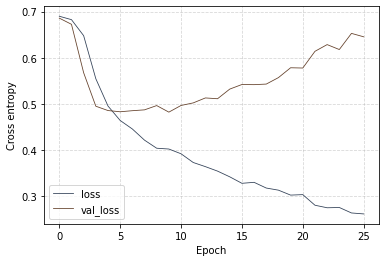

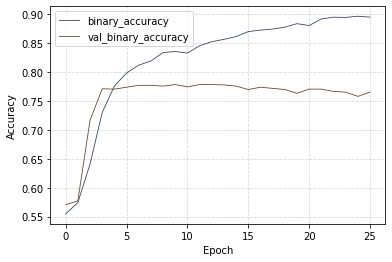

In [14]:
# define an early stopping callback
early_stopping = callbacks.EarlyStopping(
    min_delta = 0.001, # minimium amount of change to count as an improvement
    patience = 20, # how many epochs to wait before stopping
    restore_best_weights = True, # restore the model weights when validation loss is minimized
)

# model definition
model = keras.Sequential([
    layers.Dense(32, activation = 'relu', 
                 input_shape = [hparams['max_sequence_length']]
                 ),
    layers.Dropout(rate = 0.3),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(rate = 0.3),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(rate = 0.3),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(rate = 0.3),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(rate = 0.3),
    layers.Dense(1, activation = 'sigmoid')
])

# set optimizer, loss and perforamnce metrics
model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics = ['binary_accuracy']
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=hparams['batch_size'],
    epochs=hparams['epochs'],
    callbacks=[early_stopping]
)

# plot the learning curves
history_df = pd.DataFrame(history.history)
f = plt.figure(figsize = (6,4))
ax = f.add_subplot(1,1,1)
history_df.loc[:, ['loss', 'val_loss']].plot(ax = ax, color = ['#324157', '#64412B'],
                                             linewidth = 0.8,
                                             linestyle = '-')
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross entropy')
ax.grid(True, alpha = 0.5, linestyle = '--', zorder = -1)

f = plt.figure(figsize = (6,4))
ax = f.add_subplot(1,1,1)
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(ax = ax,
                                                                   color = ['#324157', '#64412B'],
                                                                   linewidth = 0.8,
                                                                   linestyle = '-')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.grid(True, alpha = 0.5, linestyle = '--', zorder = -1)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(X_valid[:3])
print('Probabilities:')
print(predictions)
bin_predictions = tf.greater(predictions, .3).numpy()
print('Class predictions:')
print(bin_predictions)


Lets check the F1 score on the validation set with the optimal parameters and see how it compares.

F1 score: 0.730
----- Confusion Matrix -----
[[693 177]
 [176 477]]


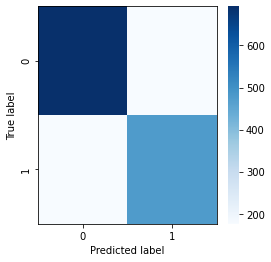

In [15]:
predictions = model.predict(X_valid)
# TensorFlow returns probabilities from the sigmoid output layer - convert to binary
bin_predictions = tf.greater(predictions, .3).numpy()

f1score = f1_score(bin_predictions, y_valid)
print('F1 score: {:.3f}'.format(f1score))

# compute confusion matrix
cf = confusion_matrix(bin_predictions, y_valid)
print('----- Confusion Matrix -----')
print(cf)

#  plot_confusion_matrix only handles classifiers, so we will create our own plot
f = plt.figure(figsize = (4,4))
ax = f.add_subplot(1,1,1)
p = sns.heatmap(cf, cmap = 'Blues', ax = ax)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

On the validation set we get an F1 score of 0.730, and an accuracy of 77% - our best score yet! We avoid over-fitting by implementing early stopping and based on the confusion matrix/f1_score, we see that the neural network is best suited for capturing the non-linearities in the data set. Though, the performance is not substantially better than the linear model or logistic regression in it's current form. Note that there is a lot of room for hyperparameter optimization for the deep learning network, which should be leveraged to improve the performance as much as possible without over-fitting.

---

### Conclusions/comments

In this notebook, we used natural language processing techniques to perform sentiment analysis of tweets for identifying disasters. We cleaned the data using a series of regular expressions, removed stop words from the built-up vocabulary, lematized the words and then tokenized each tweet. These vectors were then fed into various classication models and their performance was evaluated using Kfold cross-validation. In the end, the best-performing model was the deep nerual network, followed by logistic regression. The worst performing model (based on relatively standard hyperparameters), was the xgboost model. 

The performance of all models could be optimized with more in-depth hyperparameter tuning, using the same cross-validation framework used here. Regarding the deep NN model, there is an abundance of parameters that could be tuned such as learning rate, number of hidden layers, numbber of neurons per layer, activation function for each layer, the fraction of neuron to dropout between each layer during training, etc. In order to get the biggest performance gains, it is likely that we would need to consider more advanced deep learning models. For example attention models, and numerous transformer models (BERT, ALBERT, DistilBERT, GPT3, etc.) are the state-of-the-art for deep learning performance. However, I need to study these models in more depth to understand their functionality before attempting to implement them.